In [10]:
# Imports and plotting setup
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from option_pricing import bs_delta_hedge

In [11]:
# Common parameters for all experiments
spot = 100.0
strike = 100.0
expiry = 1.0  # years
rate = 0.01
dividend_yield = 0.0
sim_vol = 0.2
base_mark_vol = 0.2
n_steps = 252
hedge_freq_daily = 252
n_paths = 500

hist_min = -5.0
hist_max = 5.0
n_bins = 100

In [12]:
# Helper to run a single experiment and return a DataFrame row
def run_experiment(product_type, payoff_type, mark_vol, hedge_freq, seed):
    result = bs_delta_hedge(
        product_type=product_type,
        payoff_type=payoff_type,
        strike=strike,
        expiry=expiry,
        rate=rate,
        dividend_yield=dividend_yield,
        spot=spot,
        sim_vol=sim_vol,
        mark_vol=mark_vol,
        n_steps=n_steps,
        hedge_freq=hedge_freq,
        n_paths=n_paths,
        hist_min=hist_min,
        hist_max=hist_max,
        n_bins=n_bins,
        seed=seed,
    )

    row = {
        "product_type": product_type,
        "payoff_type": payoff_type,
        "mark_vol": mark_vol,
        "hedge_freq": hedge_freq,
        "pnl_mean": result["pnl_mean"],
        "pnl_std": result["pnl_std"],
        "hist_bin_edges": result["hist_bin_edges"],
        "hist_counts": result["hist_counts"],
    }
    return row

## Effect of Volatility Misspecification

We fix the simulation volatility and hedging frequency, and vary the
mark-to-market volatility used for pricing and delta hedging.

In [13]:
mark_vols = [0.12, 0.16, 0.2, 0.24, 0.3]
products = [("european", "call"), ("european", "put"), ("digital", "call"), ("digital", "put")]

rows = []
for product_type, payoff_type in products:
    for mv in mark_vols:
        row = run_experiment(
            product_type=product_type,
            payoff_type=payoff_type,
            mark_vol=mv,
            hedge_freq=hedge_freq_daily,
            seed=42,
        )
        rows.append(row)

misspec_df = pd.DataFrame(rows)
misspec_df[["product_type", "payoff_type", "mark_vol", "pnl_mean", "pnl_std"]]

,product_type,payoff_type,mark_vol,pnl_mean,pnl_std
0,european,call,0.12,3.092527,1.602129
1,european,call,0.16,1.570594,0.809730
2,european,call,0.20,0.032032,0.412730
3,european,call,0.24,-1.520797,0.678197
4,european,call,0.30,-3.866223,1.264427
5,european,put,0.12,3.092527,1.602129
6,european,put,0.16,1.570594,0.809730
7,european,put,0.20,0.032032,0.412730
8,european,put,0.24,-1.520797,0.678197
9,european,put,0.30,-3.866223,1.264427


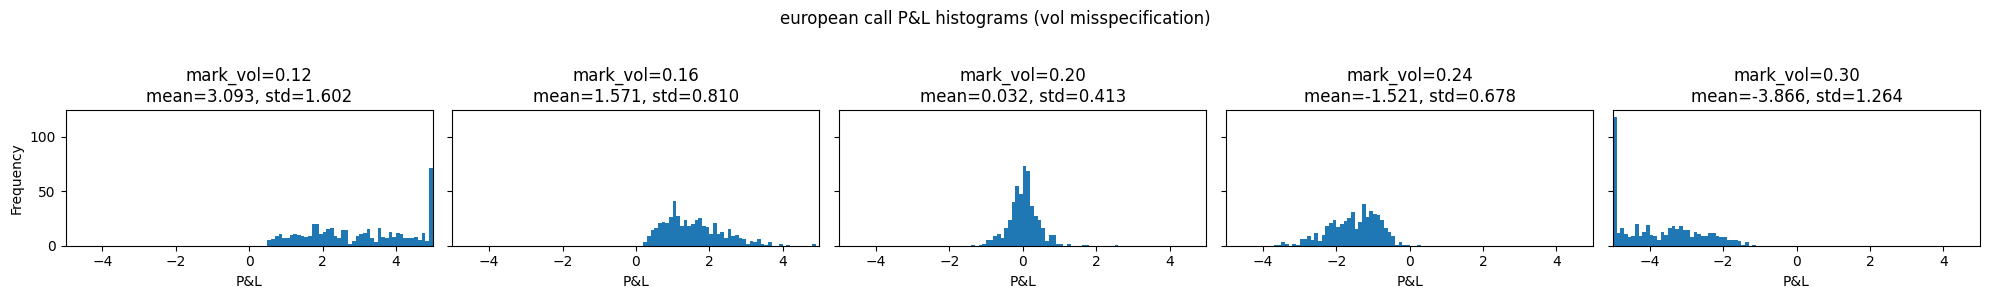

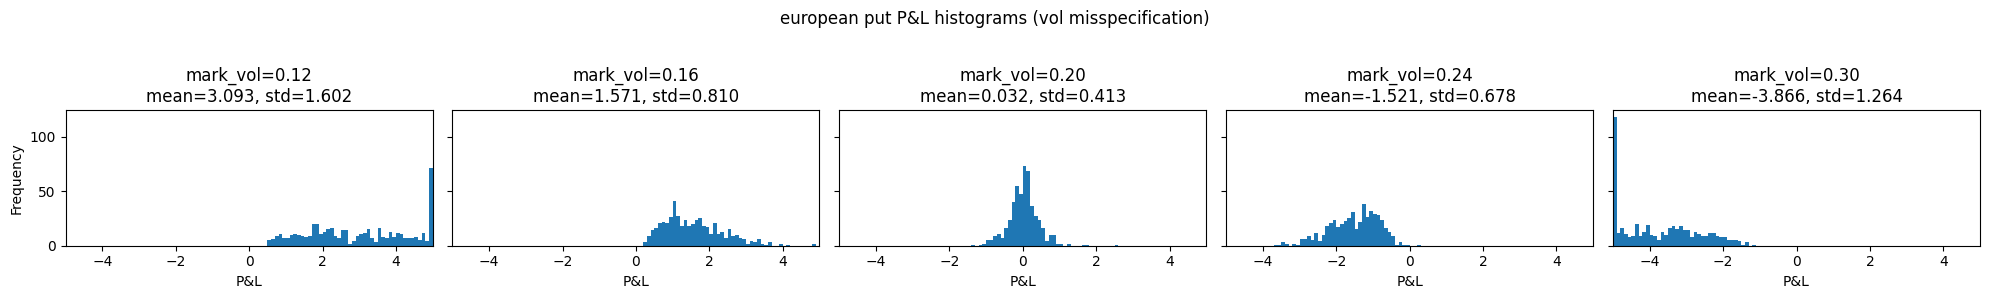

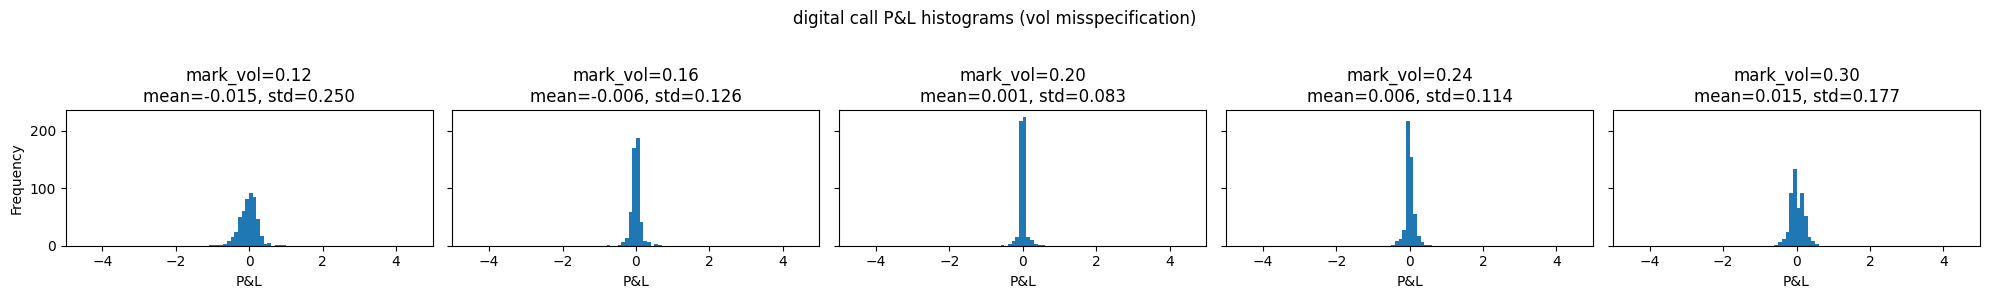

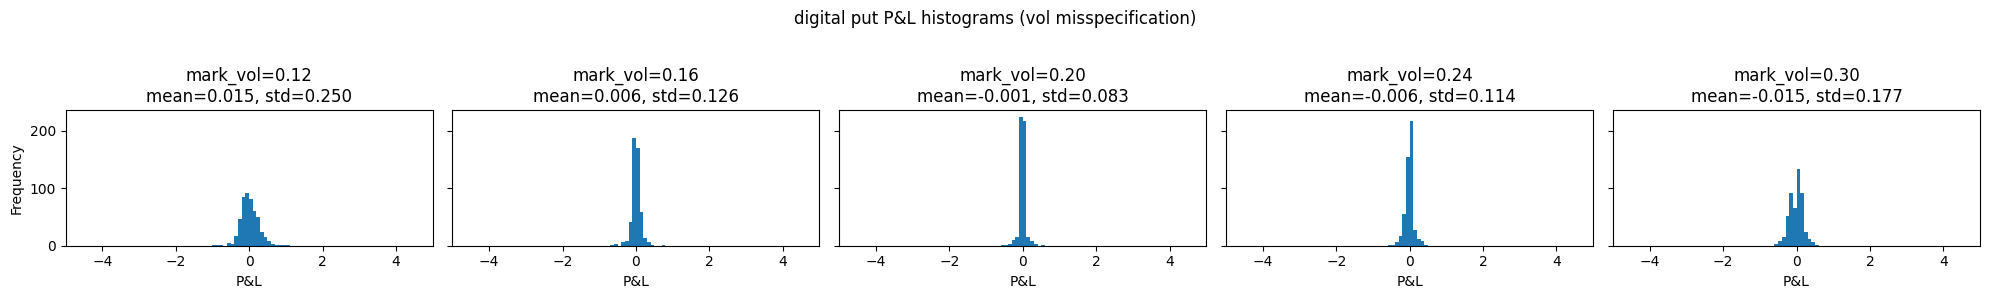

In [14]:
# Plot P&L histograms for volatility misspecification for each product/payoff
def plot_histograms_for_product(product_type, payoff_type):
    subset = misspec_df[(misspec_df.product_type == product_type) & (misspec_df.payoff_type == payoff_type)].sort_values("mark_vol")
    n = len(subset)
    fig, axes = plt.subplots(1, n, figsize=(4 * n, 3), sharey=True)
    if n == 1:
        axes = [axes]

    for ax, (_, row) in zip(axes, subset.iterrows()):
        edges = np.asarray(row["hist_bin_edges"])
        counts = np.asarray(row["hist_counts"])
        centers = 0.5 * (edges[:-1] + edges[1:])
        width = edges[1] - edges[0]
        ax.bar(centers, counts, width=width, align="center")
        ax.set_xlim(hist_min, hist_max)
        ax.set_title(f"mark_vol={row['mark_vol']:.2f}\nmean={row['pnl_mean']:.3f}, std={row['pnl_std']:.3f}")
        ax.set_xlabel("P&L")
    axes[0].set_ylabel("Frequency")
    fig.suptitle(f"{product_type} {payoff_type} P&L histograms (vol misspecification)")
    plt.tight_layout(rect=[0, 0, 1, 0.95])

for product_type, payoff_type in products:
    plot_histograms_for_product(product_type, payoff_type)

## Effect of Hedging Frequency

We now fix sim_vol = mark_vol and vary the hedging frequency.

In [15]:
hedge_freqs = [252, 52, 12, 4]
rows_freq = []
for product_type, payoff_type in products:
    for hf in hedge_freqs:
        row = run_experiment(
            product_type=product_type,
            payoff_type=payoff_type,
            mark_vol=base_mark_vol,
            hedge_freq=hf,
            seed=123,
        )
        rows_freq.append(row)

freq_df = pd.DataFrame(rows_freq)
freq_df[["product_type", "payoff_type", "hedge_freq", "pnl_mean", "pnl_std"]]

,product_type,payoff_type,hedge_freq,pnl_mean,pnl_std
0,european,call,252,-0.027944,0.454898
1,european,call,52,-0.059733,0.926024
2,european,call,12,-0.097422,1.814618
3,european,call,4,-0.135546,3.205446
4,european,put,252,-0.027944,0.454898
5,european,put,52,-0.059733,0.926024
6,european,put,12,-0.097422,1.814618
7,european,put,4,-0.135546,3.205446
8,digital,call,252,-0.001382,0.103998
9,digital,call,52,0.003983,0.150470


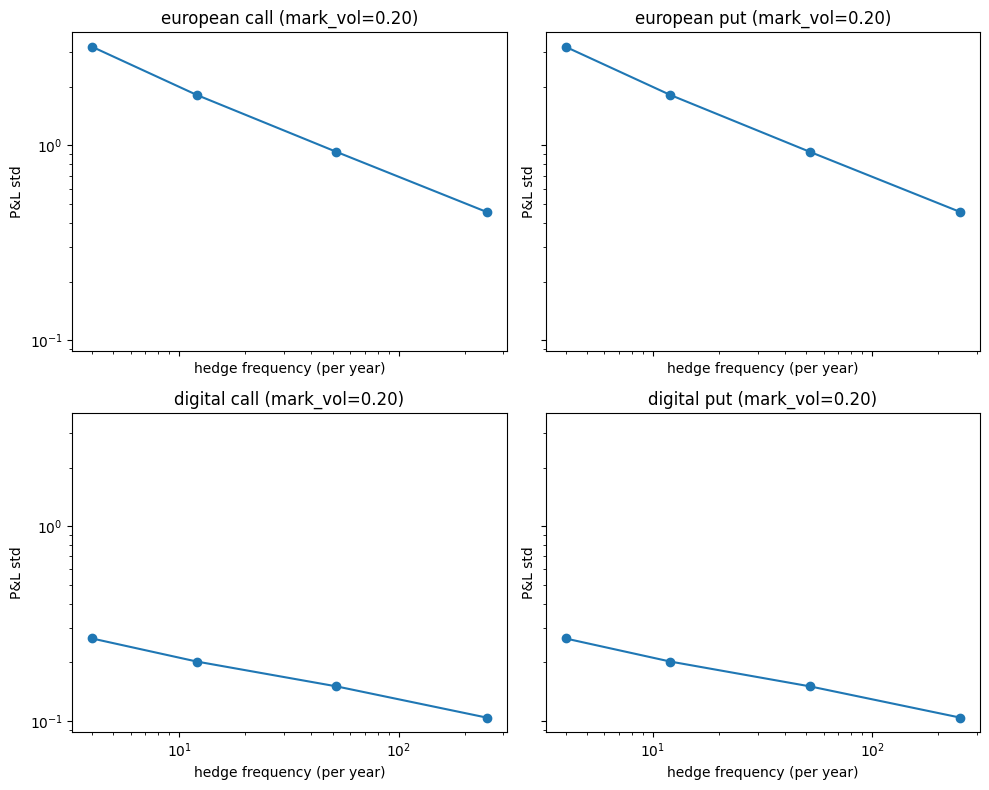

In [16]:
# Plot how P&L standard deviation scales with hedging frequency
fig, axes = plt.subplots(2, 2, figsize=(10, 8), sharex=True, sharey=True)
axes = axes.ravel()
for ax, (product_type, payoff_type) in zip(axes, products):
    subset = freq_df[(freq_df.product_type == product_type) & (freq_df.payoff_type == payoff_type)]
    ax.plot(subset["hedge_freq"], subset["pnl_std"], marker="o")
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_title(f"{product_type} {payoff_type} (mark_vol={base_mark_vol:.2f})")
    ax.set_xlabel("hedge frequency (per year)")
    ax.set_ylabel("P&L std")
plt.tight_layout()

In [17]:
# Optional: export summary statistics to CSV for spreadsheet analysis
display(misspec_df)
display(freq_df)

,product_type,payoff_type,mark_vol,hedge_freq,pnl_mean,pnl_std,hist_bin_edges,hist_counts
0,european,call,0.12,252,3.092527,1.602129,"[-5.0, -4.9, -4.8, -4.7, -4.6, -4.5, -4.4, -4....","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,european,call,0.16,252,1.570594,0.809730,"[-5.0, -4.9, -4.8, -4.7, -4.6, -4.5, -4.4, -4....","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,european,call,0.20,252,0.032032,0.412730,"[-5.0, -4.9, -4.8, -4.7, -4.6, -4.5, -4.4, -4....","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,european,call,0.24,252,-1.520797,0.678197,"[-5.0, -4.9, -4.8, -4.7, -4.6, -4.5, -4.4, -4....","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, ..."
4,european,call,0.30,252,-3.866223,1.264427,"[-5.0, -4.9, -4.8, -4.7, -4.6, -4.5, -4.4, -4....","[118, 12, 16, 11, 8, 9, 20, 9, 13, 19, 10, 9, ..."
5,european,put,0.12,252,3.092527,1.602129,"[-5.0, -4.9, -4.8, -4.7, -4.6, -4.5, -4.4, -4....","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
6,european,put,0.16,252,1.570594,0.809730,"[-5.0, -4.9, -4.8, -4.7, -4.6, -4.5, -4.4, -4....","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
7,european,put,0.20,252,0.032032,0.412730,"[-5.0, -4.9, -4.8, -4.7, -4.6, -4.5, -4.4, -4....","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
8,european,put,0.24,252,-1.520797,0.678197,"[-5.0, -4.9, -4.8, -4.7, -4.6, -4.5, -4.4, -4....","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, ..."
9,european,put,0.30,252,-3.866223,1.264427,"[-5.0, -4.9, -4.8, -4.7, -4.6, -4.5, -4.4, -4....","[118, 12, 16, 11, 8, 9, 20, 9, 13, 19, 10, 9, ..."


,product_type,payoff_type,mark_vol,hedge_freq,pnl_mean,pnl_std,hist_bin_edges,hist_counts
0,european,call,0.2,252,-0.027944,0.454898,"[-5.0, -4.9, -4.8, -4.7, -4.6, -4.5, -4.4, -4....","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,european,call,0.2,52,-0.059733,0.926024,"[-5.0, -4.9, -4.8, -4.7, -4.6, -4.5, -4.4, -4....","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ..."
2,european,call,0.2,12,-0.097422,1.814618,"[-5.0, -4.9, -4.8, -4.7, -4.6, -4.5, -4.4, -4....","[1, 0, 0, 1, 0, 1, 2, 1, 1, 1, 3, 2, 0, 5, 2, ..."
3,european,call,0.2,4,-0.135546,3.205446,"[-5.0, -4.9, -4.8, -4.7, -4.6, -4.5, -4.4, -4....","[32, 2, 6, 4, 0, 2, 1, 5, 5, 2, 4, 2, 4, 4, 3,..."
4,european,put,0.2,252,-0.027944,0.454898,"[-5.0, -4.9, -4.8, -4.7, -4.6, -4.5, -4.4, -4....","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
5,european,put,0.2,52,-0.059733,0.926024,"[-5.0, -4.9, -4.8, -4.7, -4.6, -4.5, -4.4, -4....","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, ..."
6,european,put,0.2,12,-0.097422,1.814618,"[-5.0, -4.9, -4.8, -4.7, -4.6, -4.5, -4.4, -4....","[1, 0, 0, 1, 0, 1, 2, 1, 1, 1, 3, 2, 0, 5, 2, ..."
7,european,put,0.2,4,-0.135546,3.205446,"[-5.0, -4.9, -4.8, -4.7, -4.6, -4.5, -4.4, -4....","[32, 2, 6, 4, 0, 2, 1, 5, 5, 2, 4, 2, 4, 4, 3,..."
8,digital,call,0.2,252,-0.001382,0.103998,"[-5.0, -4.9, -4.8, -4.7, -4.6, -4.5, -4.4, -4....","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
9,digital,call,0.2,52,0.003983,0.150470,"[-5.0, -4.9, -4.8, -4.7, -4.6, -4.5, -4.4, -4....","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


## Effect of Moneyness (Strike Price)

We analyze how the initial moneyness of the option affects hedging performance.
ITM (In-the-Money), ATM (At-the-Money), and OTM (Out-of-the-Money) options
exhibit different hedging dynamics.

In [19]:
# Moneyness experiment: vary strike relative to spot
strikes = [80, 90, 100, 110, 120]  # spot = 100
moneyness_labels = ["Deep ITM", "ITM", "ATM", "OTM", "Deep OTM"]

rows_moneyness = []
for product_type, payoff_type in products:
    for k, label in zip(strikes, moneyness_labels):
        result = bs_delta_hedge(
            product_type=product_type,
            payoff_type=payoff_type,
            strike=k,
            expiry=expiry,
            rate=rate,
            dividend_yield=dividend_yield,
            spot=spot,
            sim_vol=sim_vol,
            mark_vol=base_mark_vol,
            n_steps=n_steps,
            hedge_freq=hedge_freq_daily,
            n_paths=n_paths,
            hist_min=hist_min,
            hist_max=hist_max,
            n_bins=n_bins,
            seed=42,
        )
        rows_moneyness.append({
            "product_type": product_type,
            "payoff_type": payoff_type,
            "strike": k,
            "moneyness": label,
            "pnl_mean": result["pnl_mean"],
            "pnl_std": result["pnl_std"],
        })

moneyness_df = pd.DataFrame(rows_moneyness)
moneyness_df

,product_type,payoff_type,strike,moneyness,pnl_mean,pnl_std
0,european,call,80,Deep ITM,0.015239,0.226956
1,european,call,90,ITM,0.006589,0.384471
2,european,call,100,ATM,0.032032,0.412730
3,european,call,110,OTM,0.033229,0.412457
4,european,call,120,Deep OTM,0.031907,0.413425
5,european,put,80,Deep ITM,0.015239,0.226956
6,european,put,90,ITM,0.006589,0.384471
7,european,put,100,ATM,0.032032,0.412730
8,european,put,110,OTM,0.033229,0.412457
9,european,put,120,Deep OTM,0.031907,0.413425


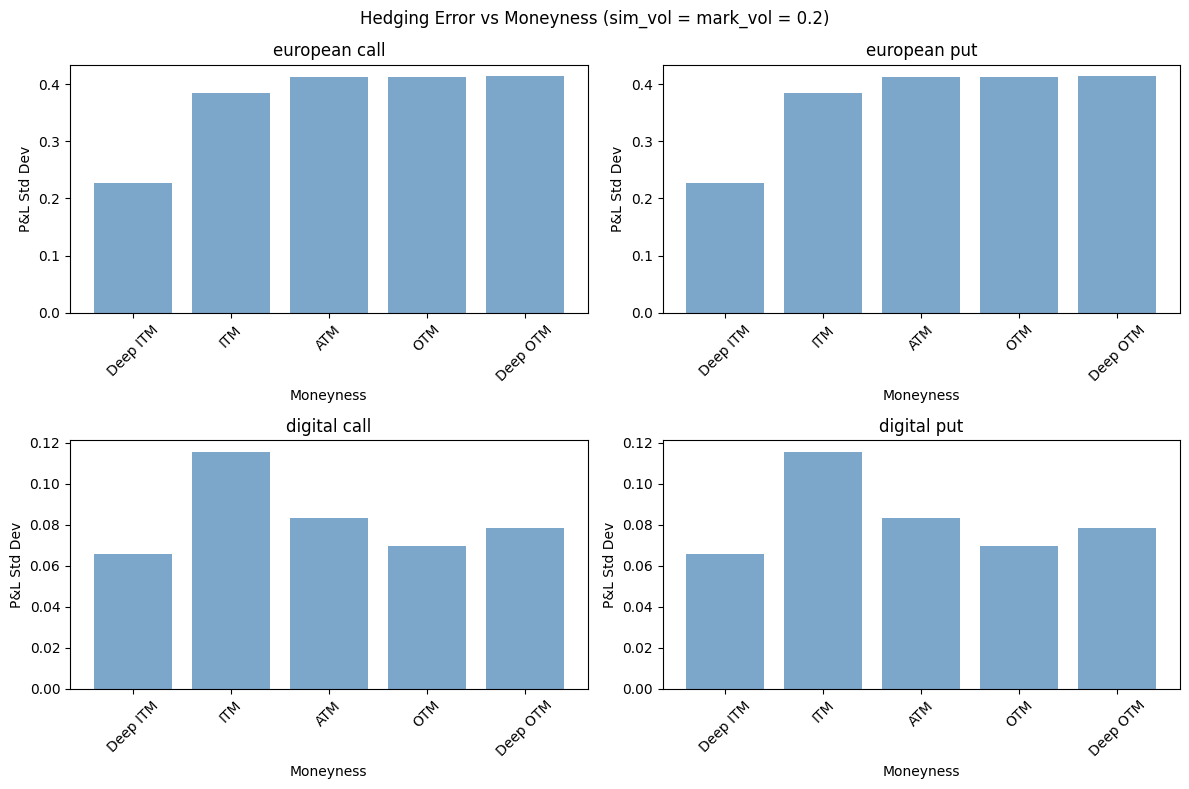

In [20]:
# Plot P&L std vs moneyness for each product type
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.ravel()

for ax, (product_type, payoff_type) in zip(axes, products):
    subset = moneyness_df[(moneyness_df.product_type == product_type) & (moneyness_df.payoff_type == payoff_type)]
    ax.bar(subset["moneyness"], subset["pnl_std"], color='steelblue', alpha=0.7)
    ax.set_title(f"{product_type} {payoff_type}")
    ax.set_xlabel("Moneyness")
    ax.set_ylabel("P&L Std Dev")
    ax.tick_params(axis='x', rotation=45)

plt.suptitle("Hedging Error vs Moneyness (sim_vol = mark_vol = 0.2)", fontsize=12)
plt.tight_layout()
plt.show()

## Effect of Time to Maturity

Shorter maturities exhibit higher gamma near expiry, leading to larger hedging errors.
We examine how P&L variance scales with option expiry.

In [21]:
# Time to maturity experiment
expiries = [0.25, 0.5, 1.0, 2.0, 3.0]  # years
expiry_labels = ["3M", "6M", "1Y", "2Y", "3Y"]

rows_expiry = []
for product_type, payoff_type in products:
    for exp, label in zip(expiries, expiry_labels):
        # Scale n_steps proportionally to expiry to maintain time step size
        steps = int(252 * exp)
        result = bs_delta_hedge(
            product_type=product_type,
            payoff_type=payoff_type,
            strike=strike,
            expiry=exp,
            rate=rate,
            dividend_yield=dividend_yield,
            spot=spot,
            sim_vol=sim_vol,
            mark_vol=base_mark_vol,
            n_steps=steps,
            hedge_freq=hedge_freq_daily,
            n_paths=n_paths,
            hist_min=hist_min,
            hist_max=hist_max,
            n_bins=n_bins,
            seed=42,
        )
        rows_expiry.append({
            "product_type": product_type,
            "payoff_type": payoff_type,
            "expiry": exp,
            "expiry_label": label,
            "pnl_mean": result["pnl_mean"],
            "pnl_std": result["pnl_std"],
        })

expiry_df = pd.DataFrame(rows_expiry)
expiry_df

,product_type,payoff_type,expiry,expiry_label,pnl_mean,pnl_std
0,european,call,0.25,3M,0.028638,0.395860
1,european,call,0.50,6M,0.018317,0.418865
2,european,call,1.00,1Y,0.032032,0.412730
3,european,call,2.00,2Y,0.009346,0.457676
4,european,call,3.00,3Y,0.011423,0.461980
5,european,put,0.25,3M,0.028638,0.395860
6,european,put,0.50,6M,0.018317,0.418865
7,european,put,1.00,1Y,0.032032,0.412730
8,european,put,2.00,2Y,0.009346,0.457676
9,european,put,3.00,3Y,0.011423,0.461980


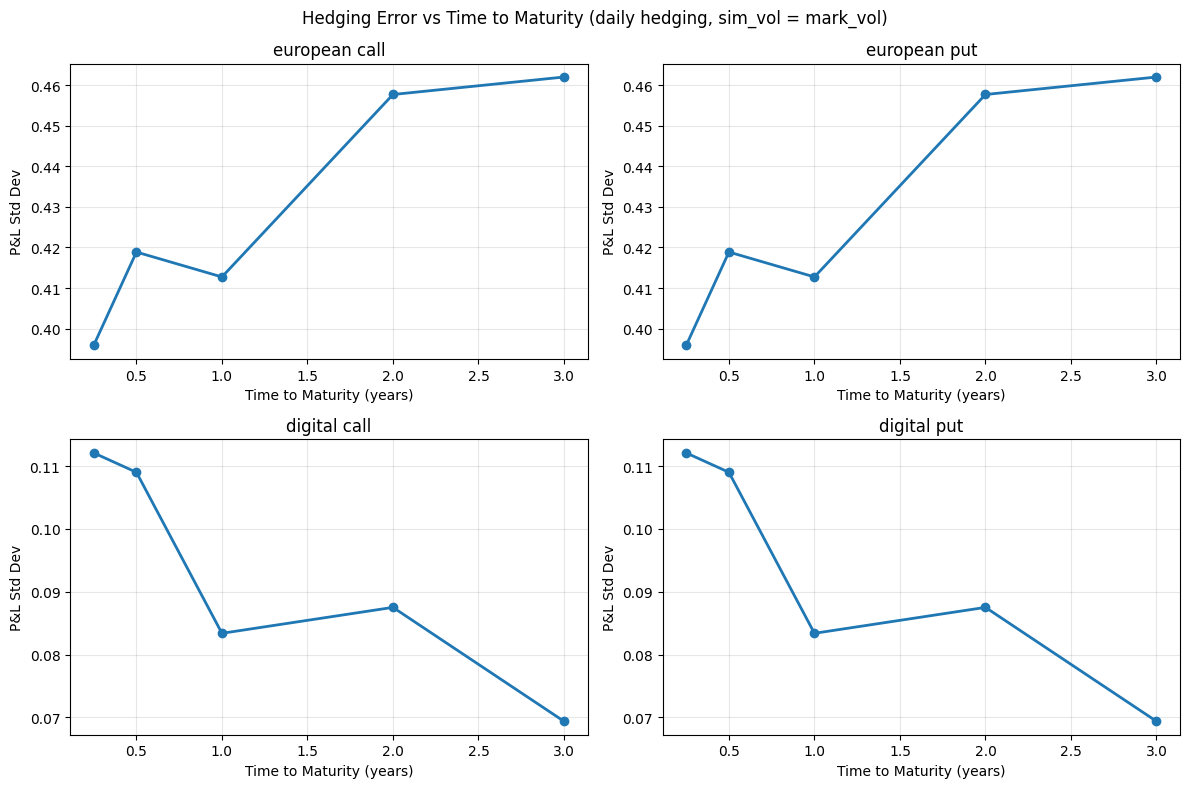

In [22]:
# Plot P&L std vs expiry
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.ravel()

for ax, (product_type, payoff_type) in zip(axes, products):
    subset = expiry_df[(expiry_df.product_type == product_type) & (expiry_df.payoff_type == payoff_type)]
    ax.plot(subset["expiry"], subset["pnl_std"], marker='o', linewidth=2)
    ax.set_title(f"{product_type} {payoff_type}")
    ax.set_xlabel("Time to Maturity (years)")
    ax.set_ylabel("P&L Std Dev")
    ax.grid(True, alpha=0.3)

plt.suptitle("Hedging Error vs Time to Maturity (daily hedging, sim_vol = mark_vol)", fontsize=12)
plt.tight_layout()
plt.show()

## Interest Rate Sensitivity

The risk-free rate affects both the option price and the cost of financing the hedge.
We examine how different interest rate environments impact hedging performance.

In [23]:
# Interest rate experiment
rates = [0.0, 0.01, 0.03, 0.05, 0.10]

rows_rate = []
for product_type, payoff_type in products:
    for r in rates:
        result = bs_delta_hedge(
            product_type=product_type,
            payoff_type=payoff_type,
            strike=strike,
            expiry=expiry,
            rate=r,
            dividend_yield=dividend_yield,
            spot=spot,
            sim_vol=sim_vol,
            mark_vol=base_mark_vol,
            n_steps=n_steps,
            hedge_freq=hedge_freq_daily,
            n_paths=n_paths,
            hist_min=hist_min,
            hist_max=hist_max,
            n_bins=n_bins,
            seed=42,
        )
        rows_rate.append({
            "product_type": product_type,
            "payoff_type": payoff_type,
            "rate": r,
            "pnl_mean": result["pnl_mean"],
            "pnl_std": result["pnl_std"],
        })

rate_df = pd.DataFrame(rows_rate)
rate_df

,product_type,payoff_type,rate,pnl_mean,pnl_std
0,european,call,0.00,0.026483,0.404028
1,european,call,0.01,0.032032,0.412730
2,european,call,0.03,0.022747,0.421000
3,european,call,0.05,0.025567,0.424250
4,european,call,0.10,0.015038,0.423470
5,european,put,0.00,0.026483,0.404028
6,european,put,0.01,0.032032,0.412730
7,european,put,0.03,0.022747,0.421000
8,european,put,0.05,0.025567,0.424250
9,european,put,0.10,0.015038,0.423470


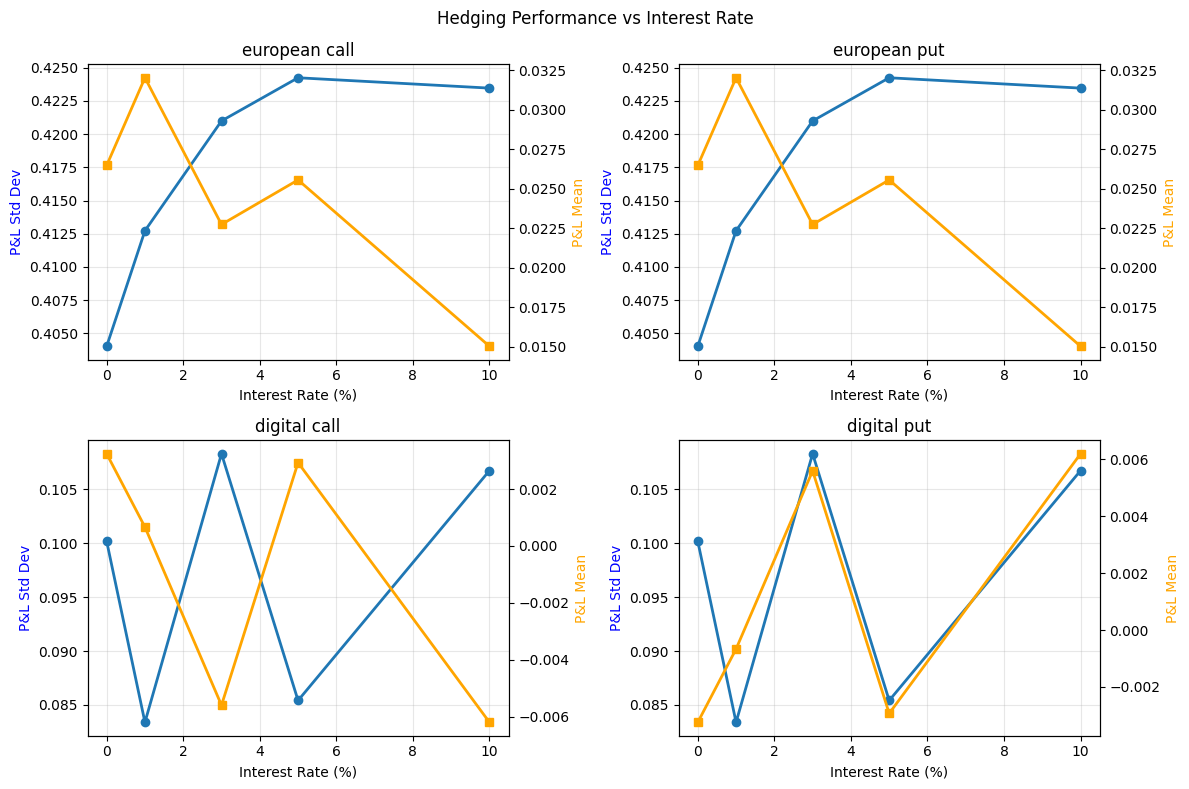

In [24]:
# Plot P&L statistics vs interest rate
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.ravel()

for ax, (product_type, payoff_type) in zip(axes, products):
    subset = rate_df[(rate_df.product_type == product_type) & (rate_df.payoff_type == payoff_type)]
    ax.plot(subset["rate"] * 100, subset["pnl_std"], marker='o', linewidth=2, label='P&L Std')
    ax2 = ax.twinx()
    ax2.plot(subset["rate"] * 100, subset["pnl_mean"], marker='s', linewidth=2, color='orange', label='P&L Mean')
    ax.set_title(f"{product_type} {payoff_type}")
    ax.set_xlabel("Interest Rate (%)")
    ax.set_ylabel("P&L Std Dev", color='blue')
    ax2.set_ylabel("P&L Mean", color='orange')
    ax.grid(True, alpha=0.3)

plt.suptitle("Hedging Performance vs Interest Rate", fontsize=12)
plt.tight_layout()
plt.show()

## Volatility Level Experiment

Here we test how the absolute level of volatility (with perfect vol matching) affects hedging error.
Higher volatility leads to larger price movements and potentially larger hedging errors.

In [25]:
# Volatility level experiment (sim_vol = mark_vol)
vol_levels = [0.10, 0.15, 0.20, 0.30, 0.40, 0.50]

rows_vol_level = []
for product_type, payoff_type in products:
    for vol in vol_levels:
        result = bs_delta_hedge(
            product_type=product_type,
            payoff_type=payoff_type,
            strike=strike,
            expiry=expiry,
            rate=rate,
            dividend_yield=dividend_yield,
            spot=spot,
            sim_vol=vol,  # sim_vol = mark_vol
            mark_vol=vol,
            n_steps=n_steps,
            hedge_freq=hedge_freq_daily,
            n_paths=n_paths,
            hist_min=hist_min,
            hist_max=hist_max,
            n_bins=n_bins,
            seed=42,
        )
        rows_vol_level.append({
            "product_type": product_type,
            "payoff_type": payoff_type,
            "volatility": vol,
            "pnl_mean": result["pnl_mean"],
            "pnl_std": result["pnl_std"],
        })

vol_level_df = pd.DataFrame(rows_vol_level)
vol_level_df

,product_type,payoff_type,volatility,pnl_mean,pnl_std
0,european,call,0.10,0.011299,0.210383
1,european,call,0.15,0.022206,0.315130
2,european,call,0.20,0.032032,0.412730
3,european,call,0.30,0.038568,0.600515
4,european,call,0.40,0.045275,0.787778
5,european,call,0.50,0.059403,0.976968
6,european,put,0.10,0.011299,0.210383
7,european,put,0.15,0.022206,0.315130
8,european,put,0.20,0.032032,0.412730
9,european,put,0.30,0.038568,0.600515


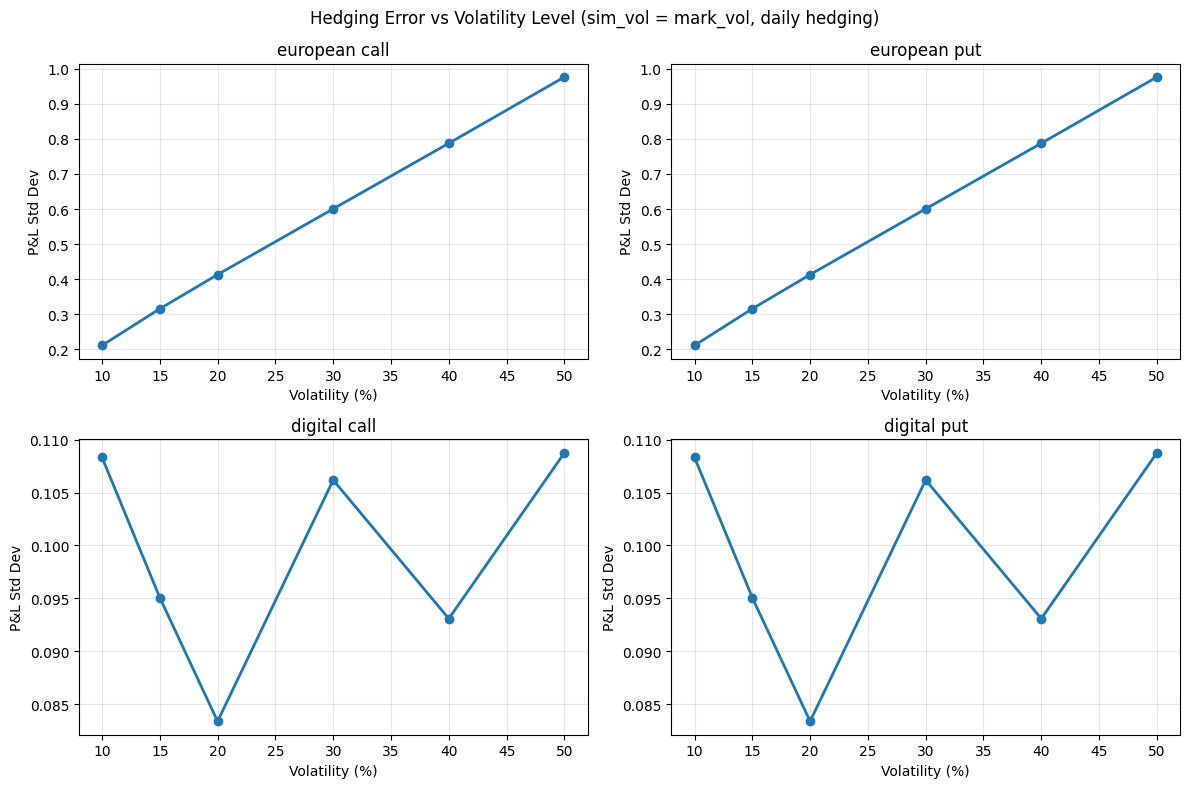

In [26]:
# Plot P&L std vs volatility level
fig, axes = plt.subplots(2, 2, figsize=(12, 8))
axes = axes.ravel()

for ax, (product_type, payoff_type) in zip(axes, products):
    subset = vol_level_df[(vol_level_df.product_type == product_type) & (vol_level_df.payoff_type == payoff_type)]
    ax.plot(subset["volatility"] * 100, subset["pnl_std"], marker='o', linewidth=2)
    ax.set_title(f"{product_type} {payoff_type}")
    ax.set_xlabel("Volatility (%)")
    ax.set_ylabel("P&L Std Dev")
    ax.grid(True, alpha=0.3)

plt.suptitle("Hedging Error vs Volatility Level (sim_vol = mark_vol, daily hedging)", fontsize=12)
plt.tight_layout()
plt.show()

## Combined Analysis: Volatility Misspecification × Hedging Frequency

This is a key experiment for understanding the interaction between model risk (volatility misspecification)
and discrete hedging effects. We create a 2D heatmap of P&L standard deviation.

In [27]:
# Combined experiment: vol misspecification × hedging frequency
combined_mark_vols = [0.15, 0.18, 0.20, 0.22, 0.25]
combined_hedge_freqs = [252, 126, 52, 26, 12]

rows_combined = []
for product_type, payoff_type in [("european", "call"), ("digital", "call")]:  # Focus on calls for clarity
    for mv in combined_mark_vols:
        for hf in combined_hedge_freqs:
            result = bs_delta_hedge(
                product_type=product_type,
                payoff_type=payoff_type,
                strike=strike,
                expiry=expiry,
                rate=rate,
                dividend_yield=dividend_yield,
                spot=spot,
                sim_vol=sim_vol,  # true vol = 0.2
                mark_vol=mv,
                n_steps=n_steps,
                hedge_freq=hf,
                n_paths=n_paths,
                hist_min=hist_min,
                hist_max=hist_max,
                n_bins=n_bins,
                seed=42,
            )
            rows_combined.append({
                "product_type": product_type,
                "payoff_type": payoff_type,
                "mark_vol": mv,
                "hedge_freq": hf,
                "vol_error": (mv - sim_vol) / sim_vol * 100,  # % error
                "pnl_mean": result["pnl_mean"],
                "pnl_std": result["pnl_std"],
            })

combined_df = pd.DataFrame(rows_combined)
combined_df

,product_type,payoff_type,mark_vol,hedge_freq,vol_error,pnl_mean,pnl_std
0,european,call,0.15,252,-25.0,1.952604,0.982671
1,european,call,0.15,126,-25.0,1.940239,1.021834
2,european,call,0.15,52,-25.0,1.921987,1.271137
3,european,call,0.15,26,-25.0,1.834778,1.529123
4,european,call,0.15,12,-25.0,1.927879,2.075334
5,european,call,0.18,252,-10.0,0.803353,0.532967
6,european,call,0.18,126,-10.0,0.797581,0.655837
7,european,call,0.18,52,-10.0,0.740751,0.972376
8,european,call,0.18,26,-10.0,0.664134,1.310696
9,european,call,0.18,12,-10.0,0.770701,1.914989


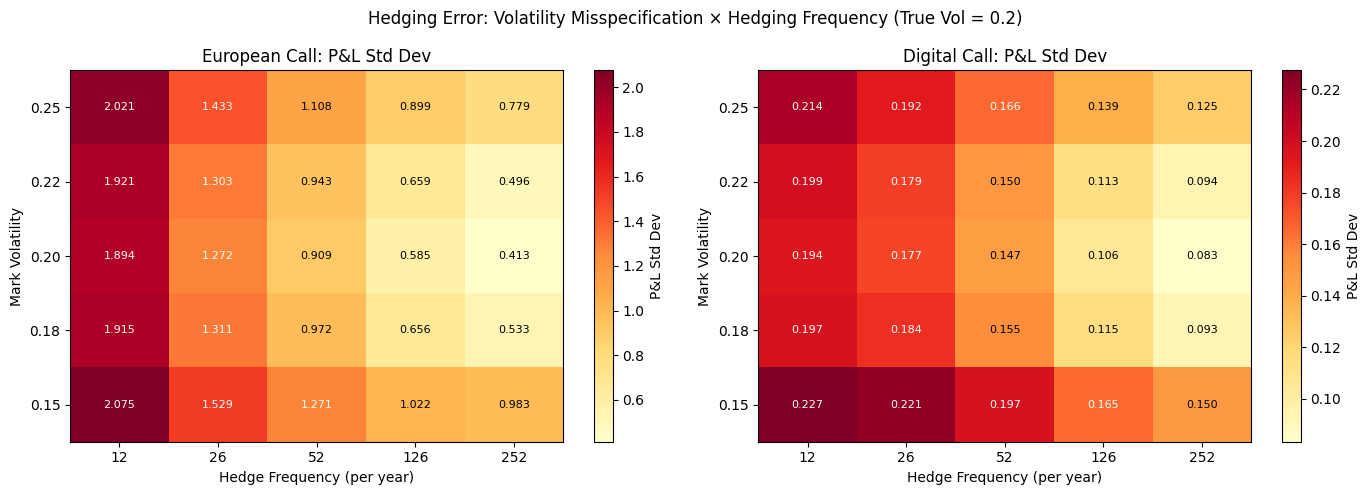

In [28]:
# Create heatmaps for European and Digital options
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for ax, product_type in zip(axes, ["european", "digital"]):
    subset = combined_df[(combined_df.product_type == product_type) & (combined_df.payoff_type == "call")]
    pivot = subset.pivot(index="mark_vol", columns="hedge_freq", values="pnl_std")
    pivot = pivot.sort_index(ascending=False)  # Higher vol on top
    
    im = ax.imshow(pivot.values, aspect='auto', cmap='YlOrRd')
    ax.set_xticks(range(len(pivot.columns)))
    ax.set_xticklabels([str(int(x)) for x in pivot.columns])
    ax.set_yticks(range(len(pivot.index)))
    ax.set_yticklabels([f"{x:.2f}" for x in pivot.index])
    ax.set_xlabel("Hedge Frequency (per year)")
    ax.set_ylabel("Mark Volatility")
    ax.set_title(f"{product_type.title()} Call: P&L Std Dev")
    
    # Add text annotations
    for i in range(len(pivot.index)):
        for j in range(len(pivot.columns)):
            val = pivot.values[i, j]
            ax.text(j, i, f"{val:.3f}", ha='center', va='center', fontsize=8,
                   color='white' if val > pivot.values.mean() else 'black')
    
    plt.colorbar(im, ax=ax, label='P&L Std Dev')

plt.suptitle(f"Hedging Error: Volatility Misspecification × Hedging Frequency (True Vol = {sim_vol})", fontsize=12)
plt.tight_layout()
plt.show()

## Comparison: European vs Digital Options

Digital options have discontinuous payoffs which lead to exploding gamma near the strike at expiry.
This makes them significantly harder to hedge with standard delta hedging.

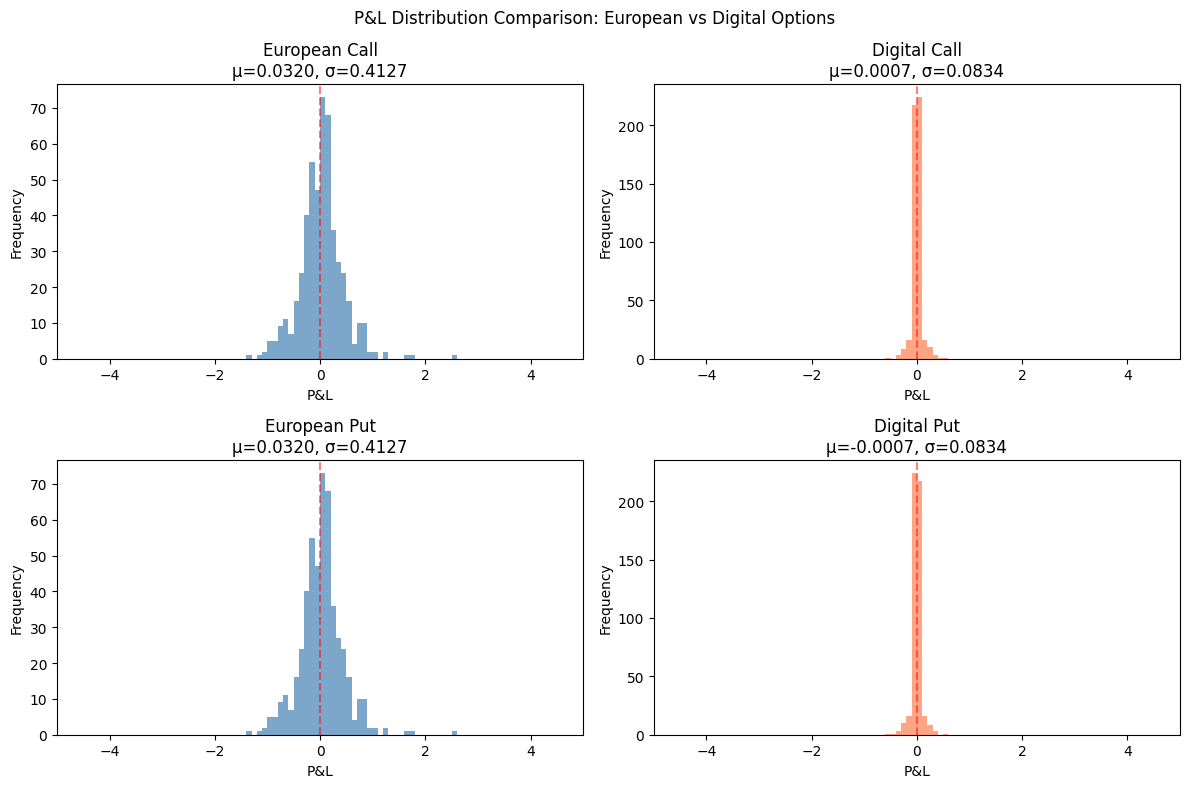

In [29]:
# Direct comparison of European vs Digital hedging performance
comparison_data = []

# Run with same parameters for both
for product_type in ["european", "digital"]:
    for payoff_type in ["call", "put"]:
        result = bs_delta_hedge(
            product_type=product_type,
            payoff_type=payoff_type,
            strike=strike,
            expiry=expiry,
            rate=rate,
            dividend_yield=dividend_yield,
            spot=spot,
            sim_vol=sim_vol,
            mark_vol=base_mark_vol,
            n_steps=n_steps,
            hedge_freq=hedge_freq_daily,
            n_paths=n_paths,
            hist_min=hist_min,
            hist_max=hist_max,
            n_bins=n_bins,
            seed=42,
        )
        comparison_data.append({
            "product_type": product_type,
            "payoff_type": payoff_type,
            "pnl_mean": result["pnl_mean"],
            "pnl_std": result["pnl_std"],
            "hist_bin_edges": result["hist_bin_edges"],
            "hist_counts": result["hist_counts"],
        })

comparison_df = pd.DataFrame(comparison_data)

# Side-by-side histograms
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

for i, payoff_type in enumerate(["call", "put"]):
    for j, product_type in enumerate(["european", "digital"]):
        ax = axes[i, j]
        row = comparison_df[(comparison_df.product_type == product_type) & (comparison_df.payoff_type == payoff_type)].iloc[0]
        edges = np.asarray(row["hist_bin_edges"])
        counts = np.asarray(row["hist_counts"])
        centers = 0.5 * (edges[:-1] + edges[1:])
        width = edges[1] - edges[0]
        ax.bar(centers, counts, width=width, alpha=0.7, color='steelblue' if product_type == 'european' else 'coral')
        ax.axvline(x=0, color='red', linestyle='--', alpha=0.5)
        ax.set_title(f"{product_type.title()} {payoff_type.title()}\nμ={row['pnl_mean']:.4f}, σ={row['pnl_std']:.4f}")
        ax.set_xlabel("P&L")
        ax.set_ylabel("Frequency")
        ax.set_xlim(hist_min, hist_max)

plt.suptitle("P&L Distribution Comparison: European vs Digital Options", fontsize=12)
plt.tight_layout()
plt.show()

## Scaling Analysis: P&L Std vs 1/√(hedge_freq)

Under Black-Scholes assumptions with perfect volatility specification, the hedging error
should scale approximately as $\sigma_{P\&L} \propto \frac{1}{\sqrt{N}}$ where $N$ is the
number of hedging intervals. We verify this theoretical relationship.

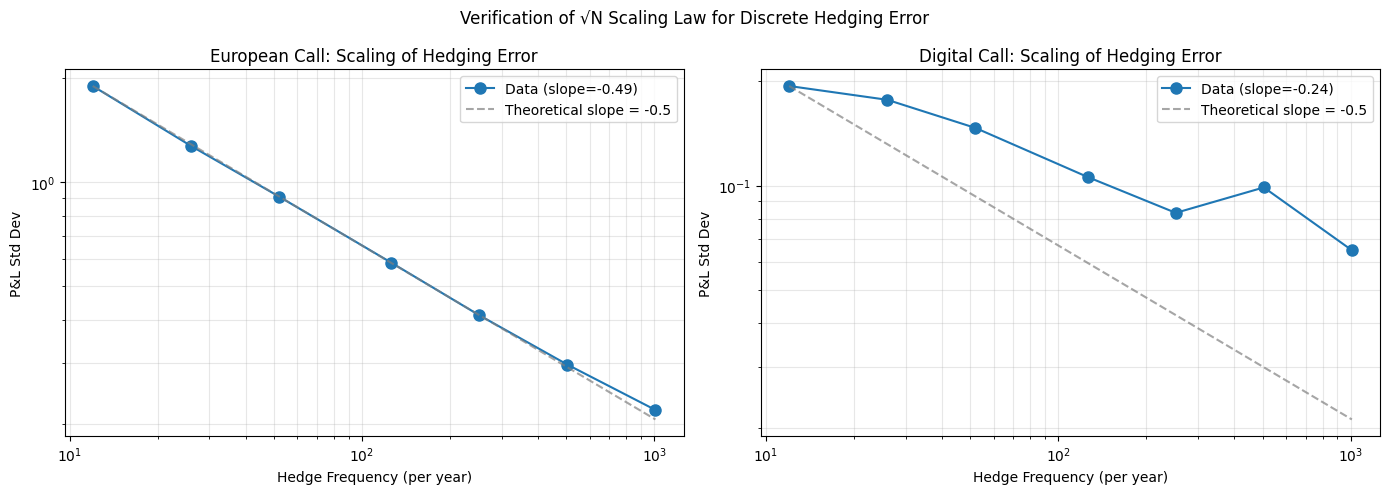

European call: fitted slope = -0.488
Digital call: fitted slope = -0.241


In [30]:
# Scaling analysis with more granular hedge frequencies
scaling_hedge_freqs = [12, 26, 52, 126, 252, 504, 1008]

rows_scaling = []
for product_type, payoff_type in [("european", "call"), ("digital", "call")]:
    for hf in scaling_hedge_freqs:
        result = bs_delta_hedge(
            product_type=product_type,
            payoff_type=payoff_type,
            strike=strike,
            expiry=expiry,
            rate=rate,
            dividend_yield=dividend_yield,
            spot=spot,
            sim_vol=sim_vol,
            mark_vol=sim_vol,  # Perfect vol matching
            n_steps=max(n_steps, hf),  # Ensure enough simulation steps
            hedge_freq=hf,
            n_paths=n_paths,
            hist_min=hist_min,
            hist_max=hist_max,
            n_bins=n_bins,
            seed=42,
        )
        rows_scaling.append({
            "product_type": product_type,
            "payoff_type": payoff_type,
            "hedge_freq": hf,
            "sqrt_hedge_freq": np.sqrt(hf),
            "inv_sqrt_hedge_freq": 1 / np.sqrt(hf),
            "pnl_std": result["pnl_std"],
        })

scaling_df = pd.DataFrame(rows_scaling)

# Plot scaling relationship
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for ax, product_type in zip(axes, ["european", "digital"]):
    subset = scaling_df[scaling_df.product_type == product_type]
    
    # Fit a line in log-log space
    log_x = np.log(subset["hedge_freq"].values)
    log_y = np.log(subset["pnl_std"].values)
    slope, intercept = np.polyfit(log_x, log_y, 1)
    
    ax.loglog(subset["hedge_freq"], subset["pnl_std"], 'o-', label=f"Data (slope={slope:.2f})", markersize=8)
    
    # Reference line with slope -0.5
    x_ref = np.array([12, 1008])
    y_ref = subset["pnl_std"].iloc[0] * (x_ref[0] / x_ref) ** 0.5
    ax.loglog(x_ref, y_ref, '--', color='gray', alpha=0.7, label='Theoretical slope = -0.5')
    
    ax.set_xlabel("Hedge Frequency (per year)")
    ax.set_ylabel("P&L Std Dev")
    ax.set_title(f"{product_type.title()} Call: Scaling of Hedging Error")
    ax.legend()
    ax.grid(True, alpha=0.3, which='both')

plt.suptitle("Verification of √N Scaling Law for Discrete Hedging Error", fontsize=12)
plt.tight_layout()
plt.show()

print(f"European call: fitted slope = {np.polyfit(np.log(scaling_df[scaling_df.product_type=='european']['hedge_freq']), np.log(scaling_df[scaling_df.product_type=='european']['pnl_std']), 1)[0]:.3f}")
print(f"Digital call: fitted slope = {np.polyfit(np.log(scaling_df[scaling_df.product_type=='digital']['hedge_freq']), np.log(scaling_df[scaling_df.product_type=='digital']['pnl_std']), 1)[0]:.3f}")

## Key Findings Summary

Based on the experiments above, the key findings for the report are:

1. **Volatility Misspecification**: 
   - When mark_vol > sim_vol, we over-hedge (higher option price, lower delta sensitivity)
   - When mark_vol < sim_vol, we under-hedge (more exposure to gamma)
   - Digital options are more sensitive to volatility misspecification due to discontinuous payoff

2. **Hedging Frequency**:
   - P&L std decreases approximately as 1/√N where N is the number of hedge intervals
   - Daily hedging significantly outperforms monthly or quarterly hedging
   - Digital options show less improvement from increased frequency near maturity

3. **Moneyness Effects**:
   - ATM options have the highest gamma and are hardest to hedge perfectly
   - Deep ITM/OTM options have lower hedging errors due to lower gamma exposure

4. **Time to Maturity**:
   - Longer maturities allow more hedging opportunities, reducing total hedging error
   - Short-dated options have higher gamma near expiry, increasing hedging difficulty

5. **European vs Digital Options**:
   - Digital options exhibit significantly higher hedging errors
   - The discontinuous payoff leads to unbounded gamma near the strike at expiry
   - This is a fundamental limitation of delta hedging for digital options